In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import math
import time
from sklearn.manifold import TSNE
import umap
import umap.plot   
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from wordcloud import WordCloud
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
#from scipy.misc import imread

#中文设置
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# # 连接mysql
# conn = pymysql.connect(host='39.106.2.176', user='tju',password='123456',
#                        database='dyqc')
# sql_1 = "select * from qc_task_detail"
# sql_2 = "select * from qc_task_data_2111"
# sql_3 = "select * from qc_task_data_2112"
# #利用pandas直接获取数据
# qc_data = pd.read_sql(sql_1, conn)
# qc_data_2111 = pd.read_sql(sql_2,conn)
# qc_data_2112 = pd.read_sql(sql_3,conn)
# conn.close()

In [2]:
#从数据库中读取表
def read_database(table,host,user,password,database):
    conn = pymysql.connect(host=host, user=user,password=password,
                           database=database)
    sql = "select * from "+table
    #利用pandas直接获取数据
    data = pd.read_sql(sql, conn)
    conn.close()
    return data


#将list中的json格式数据生成新列
def output_json_list(data,data_columns,columns_key):
    data[data_columns+'_'+columns_key] = data.apply(lambda x:json.loads(x[data_columns])[0].get(columns_key) if len(json.loads(x[data_columns]))!=0 else np.nan,axis = 1)

#将json格式数据生成新列
def output_json(data,data_columns,columns_key):
    data[data_columns+'_'+columns_key] = data.apply(lambda x:json.loads(x[data_columns]).get(columns_key) if len(json.loads(x[data_columns]))!=0 else np.nan,axis = 1)
    

#将时间变为年月日时分秒列
def time_connvert(data,columns):
    data[columns] = pd.to_datetime(data[columns], format='%Y-%m-%d %H:%M:%S')
    data[columns+'_year'] = data[columns].dt.year
    data[columns+'_month'] = data[columns].dt.month
    data[columns+'_day'] = data[columns].dt.day
    data[columns+'_hour'] = data[columns].dt.hour
    data[columns+'_minute'] = data[columns].dt.minute
    data[columns+'_second'] = data[columns].dt.second
    

#序号编码
def toDict(data,col):
    """
    这个函数的作用：生成替换字典，加入 col 列有两种值 A B
    则生成：{A: 0, B: 1}  即把 A 替换为 0 ， B 替换为 1
    """
    res = {}
    dic = []
    cnt = 0  
    for i in col:
        for e in data[i].unique():
            res[e] = cnt
            cnt += 1
        data = data.replace({i:res})
        cnt = 0
    return data


#查询空值
def search_null_values(data):
    print("各列是否包含空值:")
    print(data.isnull().any())
    print("各列包含空值数:")
    print(data.isnull().sum(axis=0))
#     # 顶多有 null_number 行是空值
#     null_number = sum(data.isnull().sum(axis=0))
#     # 把所有空值的行显示出来
#     print("所有包含空值的行:")
#     print(data[data.isnull().T.any()].head(null_number))
    
#删除空值
def delete_null_values(data,data_label):
#     for i in data_label_list:
    #删除列存在空值的数据
    new_data = data.dropna(subset=[data_label],inplace=False)
    #重新生成index行索引
    new_data = new_data.reset_index(drop=True)
    return new_data


#按团队分类
def class_Tju(data,advertiser_list,campaign_id_list):
    #重新生成index行索引
    data = data.reset_index(drop=True)

    #生成class_id列
    data['class_id']=''
    class_id_set = set()
    #     advertiser_list = [1696827732541517,1696898004380686,1696993595431943,1697736606312455,1702901918105607,1711685115933699,1714195536577544,1714296423936007,1716820186570759]
    #     campaign_id_list = [1701275894994999, 1707671910546491, 1710617989499931, 1711602056635412, 1711602126695463, 1711602029279243, 1711602073722932, 1712237352138804, 1713511682447380, 1713511667950603, 1713429197611028, 1713600825933843, 1713600864418931, 1713875338932260, 1714058004496420, 1714320718938164,1714510799518772, 1715209794393219, 1714780228454423, 1715568631855127, 1715569577116676, 1715569580818493, 1716417266343975, 1716724754923555, 1716724754923555, 1717177943513099, 1717449957879828, 1717992978009150, 1717996231896083, 1717996196826132, 1719191133927444, 1719411371675709, 1719681886585915]
    for i in range(len(data.index)):            
        if data['advertiser_id'][i] == advertiser_list[0] and data['campaign_id'][i] in campaign_id_list:
            data['class_id'][i] = 1
            class_id_set.add(1)
        elif data['advertiser_id'][i] == advertiser_list[1]:
            data['class_id'][i] = 2
            class_id_set.add(2)
        elif data['advertiser_id'][i] == advertiser_list[2]:
            data['class_id'][i] = 3
            class_id_set.add(3)
        elif data['advertiser_id'][i] == advertiser_list[3]:
            data['class_id'][i] = 4
            class_id_set.add(4)
        elif data['advertiser_id'][i] == advertiser_list[4]:
            data['class_id'][i] = 5
            class_id_set.add(5)
        elif data['advertiser_id'][i] == advertiser_list[5]:
            data['class_id'][i] = 6
            class_id_set.add(6)
        elif data['advertiser_id'][i] == advertiser_list[6]:
            data['class_id'][i] = 7
            class_id_set.add(7)
        elif data['advertiser_id'][i] == advertiser_list[7]:
            data['class_id'][i] = 8
            class_id_set.add(8)
        elif data['advertiser_id'][i] == advertiser_list[8]:
            data['class_id'][i] = 9
            class_id_set.add(9)
        else:
            data['class_id'][i] = 0


    #去除九类投放方以外的
    data = data[data.class_id.isin(class_id_set)]
    #重新生成index行索引
    data = data.reset_index(drop=True)
    return data


#按roi分类
def class_roi(data,data_label):
    new_data_label = 'class'+data_label
    data[new_data_label]=''
    for i in range(len(data.index)):
        if data[data_label][i] <= select_roi:
            data[new_data_label][i] = 0
        else:
            data[new_data_label][i] = 1
    return data


#表中的标签添加前缀
def add_pre_label(data,add_pre):
    temp_list = []
    for i in data.columns.values:
        i = add_pre+i
        temp_list.append(i)
    data.columns =temp_list
    return data


#分时间段  hour最大为24点
def class_time(data,data_label,mini,maxi):
    temp_list = []
    temp = '_time_hour'
    if data_label == data_label[:5]+temp: 
        if maxi == 24:
            for i in range(math.ceil(mini),24):
                temp_list.append(i)
        else:
            for i in range(math.ceil(mini),int(maxi+1)):
                temp_list.append(i)
    else:
        for i in range(math.ceil(mini),int(maxi+1)):
            temp_list.append(i)
    data = data[data.eval(data[data_label].name).isin(temp_list)]

    #重新生成index行索引
    data = data.reset_index(drop=True)
    return data


#特征类型转换
def type_to_int(data,data_label_list):
    for i in range(len(data_label_list)):
        data[data_label_list[i]] = data[data_label_list[i]].astype(int)
    return data


#保留每天最后一条数据
def today_last_data(data, min_day, max_day):
    data = data.set_index(input_time+'_time',drop=False)
    min_day_int =eval(min_day)
    max_day_int =eval(max_day)
    new_data = pd.DataFrame(columns = data.columns)
    for i in range(min_day_int,max_day_int+1):
        today_data = data['20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i):'20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i)].sort_values(by=[input_time+'_time_year',input_time+'_time_month',input_time+'_time_day',input_time+'_time_hour',input_time+'_time_minute',input_time+'_time_second'],axis=0,ascending=False)
        today_data = today_data.drop_duplicates([input_time+'_ad_id']) #删除数据记录中col3列值相同的记录       
        new_data = pd.concat([new_data,today_data])
#     #重新生成index行索引
#     new_data = new_data.reset_index(drop=True)
    return new_data

#起始时间和终止时间转为datetime格式
def time_res_select(res):
    str_ = ''
    for keys in res.keys():
        if keys == 'year' or keys == 'month':
            str_ = str_+str(res.get(keys)) +'-'
            #print(1)
        elif keys == 'day':
            str_ = str_+str(res.get(keys)) +' '
            #print(2)
        elif keys == 'hour' or keys == 'minute':
            str_ = str_+str(res.get(keys)) +':'
        elif keys == 'second':
            str_ = str_+str(res.get(keys))
            #print(3)
    cday = datetime.strptime(str_, '%Y-%m-%d %H:%M:%S')
    return cday

#提出满足时间段的数据
def class_time_interval(data, min_year,max_year,min_month,max_month,min_day,max_day,min_hour,max_hour,min_minute,max_minute,min_second,max_second):
    #筛选时间段
    _31_days_month_list = ['01','03','05','07','08','10','12']
    _30_days_month_list = ['02','04','06','09','11'] 
    if min_year != '' or max_year != '':
        if min_year != '' and max_year != '':
            data = class_time(data,input_time+'_time_year',eval(min_year),eval(max_year))
        elif min_year != '':
            max_year = time.strftime('%Y',time.localtime(time.time()))
            data = class_time(data,input_time+'_time_year',eval(min_year),eval(time.strftime('%Y',time.localtime(time.time()))))
        elif max_year != '':
            min_year = '0'
            data = class_time(data,input_time+'_time_year',0,eval(max_year)) 
    else:
        min_year = '0'
        max_year = time.strftime('%Y',time.localtime(time.time()))

    if min_month != '' or max_month != '':
        if min_month != '' and max_month != '':
            data = class_time(data,input_time+'_time_month',eval(min_month),eval(max_month))
        elif min_month != '':
            max_month = '12'
            data = class_time(data,input_time+'_time_month',eval(min_month),eval(max_month))
        elif max_month != '':
            min_month = '1'
            data = class_time(data,input_time+'_time_month',eval(min_month),eval(max_month))
    else:
        min_month = '1'
        max_month = '12'

    if min_day != '' or max_day != '':
        if min_day != '' and max_day != '':
            data = class_time(data,input_time+'_time_day',eval(min_day),eval(max_day))
        elif min_day != '':
            if input_time[3:5] in _31_days_month_list:
                max_day = '31'
                data = class_time(data,input_time+'_time_day',eval(min_day),eval(max_day))
            elif input_time[3:5] in _30_days_month_list:
                max_day = '30'
                data = class_time(data,input_time+'_time_day',eval(min_day),eval(max_day))
        elif max_day != '':
            min_day = '1'
            data = class_time(data,input_time+'_time_day',eval(min_day),eval(max_day))  
    else:
        if input_time[3:5] in _31_days_month_list:
            min_day = '1'
            max_day = '31'
        elif input_time[3:5] in _30_days_month_list:
            min_day = '1'
            max_day = '30'

    if max_hour != '' or min_hour != '':
        if max_hour != '' and min_hour != '':
            data = class_time(data,input_time+'_time_hour',eval(min_hour),eval(max_hour))
        elif min_hour != '':
            max_hour = '23'
            data = class_time(data,input_time+'_time_hour',eval(min_hour),eval(max_hour))
        elif max_hour != '':
            min_hour = '0'
            data = class_time(data,input_time+'_time_hour',eval(min_hour),eval(max_hour))
    else:
        min_hour = '0'
        max_hour = '23'

    if min_minute != '' or max_minute != '':
        if min_minute != '' and max_minute != '':
            data = class_time(data,input_time+'_time_minute',eval(min_minute),eval(max_minute))
        elif min_minute != '':
            max_minute = '59'
            data = class_time(data,input_time+'_time_minute',eval(min_minute),eval(max_minute))
        elif max_minute != '':
            min_minute = '0'
            data = class_time(data,input_time+'_time_minute',eval(min_minute),eval(max_minute))
    else:
        min_minute = '0'
        max_minute = '59'

    if min_second != '' or max_second != '':
        if min_second != '' and max_second != '':
            data = class_time(data,input_time+'_time_second',eval(min_second),eval(max_second))
        elif min_second != '':
            max_second = '59'
            data = class_time(data,input_time+'_time_second',eval(min_second),eval(max_second))
        elif max_second != '':
            min_second = '0'
            data = class_time(data,input_time+'_time_second',eval(min_second),eval(max_second))
    else:
        min_second = '0'
        max_second = '59'
    return data, min_year,max_year,min_month,max_month,min_day,max_day,min_hour,max_hour,min_minute,max_minute,min_second,max_second
    #return min_year,max_year,min_month,max_month,min_day,max_day,min_hour,max_hour,min_minute,max_minute,min_second,max_second

#提出满足起始时间到终止时间的数据
def class_time_start_end(data, start_time_res, end_time_res):
    cday = time_res_select(start_time_res)
    cday2 = time_res_select(end_time_res)
    time_list = []
    #end_time_list = []
    data_time_list = []
    for i in data[input_time+'_time']:
        data_time_list.append(i)
    for i in data_time_list:
        if cday < i < cday2:
            time_list.append(i)
    data = data[data.eval(data[input_time+'_time'].name).isin(time_list)]
    return data
    #return new_qc_data

### 数据处理

In [5]:
def data_pre_handle_toDict():
    global min_year,max_year,min_month,max_month,min_day,max_day,min_hour,max_hour,min_minute,max_minute,min_second,max_second
    # #数据库读取表
    # qc_detail = read_database("qc_task_detail",'39.106.2.176','tju','123456','dyqc')
    # qc_data = read_database("qc_task_data"+input_time,'39.106.2.176','tju','123456','dyqc')
    # #保存csv
    # qc_detail.to_csv('/Users/jiangshihua/Desktop/qc_data.csv')
    # qc_data.to_csv('/Users/jiangshihua/Desktop/qc_data'+input_time+'.csv')
    #读取csv
#     qc_detail = pd.read_csv('/Users/jiangshihua/Desktop/项目/data/qc_detail.csv')
#     qc_data = pd.read_csv('/Users/jiangshihua/Desktop/项目/data/qc_data'+input_time+'.csv')
    if not (os.path.isfile('./qc_detail.csv')):
        qc_detail = read_database("qc_task_detail",'39.106.2.176','tju','123456','dyqc')
        #保存为csv
        qc_detail.to_csv('./qc_detail.csv')
    elif (os.path.isfile('./qc_detail.csv')):
        #读取csv
        qc_detail = pd.read_csv('./qc_detail.csv')
    if not (os.path.isfile('./qc_data'+input_time+'.csv')):
        qc_data = read_database("qc_task_data"+input_time,'39.106.2.176','tju','123456','dyqc')
        #保存为csv
        qc_data.to_csv('./qc_data'+input_time+'.csv')
    elif (os.path.isfile('./qc_data'+input_time+'.csv')):
        #读取csv
        qc_data = pd.read_csv('./qc_data'+input_time+'.csv')
                                

    output_json_list(qc_detail,'aweme_info','aweme_show_id')
    output_json_list(qc_detail,'aweme_info','aweme_name')
    output_json(qc_detail,'audience','auto_extend_enabled')
    output_json(qc_detail,'audience','smart_interest_action')
    output_json(qc_detail,'audience','location_type')
    output_json(qc_detail,'audience','district')
    output_json(qc_detail,'audience','aweme_fan_behaviors_days')
    output_json(qc_detail,'audience','action_days')
    output_json(qc_detail,'audience','gender')
    output_json(qc_detail,'audience','age')
    output_json(qc_detail,'audience','city')
    output_json(qc_detail,'delivery_setting','smart_bid_type')
    output_json(qc_detail,'delivery_setting','external_action')
    output_json(qc_detail,'delivery_setting','schedule_fixed_range')
    output_json(qc_detail,'delivery_setting','budget_mode')
    output_json(qc_detail,'delivery_setting','budget')

    #删除空值
    qc_detail = delete_null_values(qc_detail,'campaign_id')
    qc_detail = delete_null_values(qc_detail,'audience_location_type')
    qc_detail = delete_null_values(qc_detail,'audience_auto_extend_enabled')
    
    
    #序号编码
    qc_detail = toDict(qc_detail,["first_industry_id","second_industry_id","third_industry_id",
                              "delivery_setting_smart_bid_type","delivery_setting_external_action",
                              "marketing_goal","promotion_way","audience_district","creative_material_mode",
                              "delivery_setting_budget_mode","audience_location_type","delivery_setting_budget"])


    #去掉Unnamed: 0列
    qc_detail = qc_detail.iloc[:,1:]
    qc_data = qc_data.iloc[:,1:]
    #表格每个标签添加前缀
    add_pre_label(qc_data,input_time+'_')
    #时间转换
    time_connvert(qc_data,input_time+'_time')
    

    if time_type == time_selcet[0]:
        qc_data = class_time_start_end(qc_data, start_time_res, end_time_res)
    elif time_type == time_selcet[1]:
        qc_data,min_year,max_year,min_month,max_month,min_day,max_day,min_hour,max_hour,min_minute,max_minute,min_second,max_second = class_time_interval(qc_data, min_year,max_year, min_month,max_month, min_day,max_day, min_hour,max_hour,min_minute,max_minute,min_second,max_second)


    qc_data = today_last_data(qc_data, min_day, max_day)
    
    return qc_data, qc_detail

### 按团队分类训练

In [20]:
def class_data_Tju(qc_data, qc_detail):
    
    #按团队分类
#     advertiser_list = [1696827732541517,1696898004380686,1696993595431943,1697736606312455,1702901918105607,1711685115933699,1714195536577544,1714296423936007,1716820186570759]
#     campaign_id_list = [1701275894994999, 1707671910546491, 1710617989499931, 1711602056635412, 1711602126695463, 1711602029279243, 1711602073722932, 1712237352138804, 1713511682447380, 1713511667950603, 1713429197611028, 1713600825933843, 1713600864418931, 1713875338932260, 1714058004496420, 1714320718938164,1714510799518772, 1715209794393219, 1714780228454423, 1715568631855127, 1715569577116676, 1715569580818493, 1716417266343975, 1716724754923555, 1716724754923555, 1717177943513099, 1717449957879828, 1717992978009150, 1717996231896083, 1717996196826132, 1719191133927444, 1719411371675709, 1719681886585915]
#     qc_detail = class_Tju(qc_detail,advertiser_list,campaign_id_list)
    # #保存为csv
    # qc_detail.to_csv('/Users/jiangshihua/Desktop/项目/data/qc_detail_Tju_toDict.csv')
    # #读取csv
    # qc_detail = pd.read_csv('/Users/jiangshihua/Desktop/项目/data/qc_detail_Tju_toDict.csv')
    # #保存为csv
    # qc_detail.to_csv('/Users/jiangshihua/Desktop/项目/data/qc_detail_Tju.csv')
    # #读取csv
    # qc_detail = pd.read_csv('/Users/jiangshihua/Desktop/项目/data/qc_detail_Tju.csv')
    if not (os.path.isfile('./qc_detail_Tju_toDict.csv')):
        #按团队分类
        advertiser_list = [1696827732541517,1696898004380686,1696993595431943,1697736606312455,1702901918105607,1711685115933699,1714195536577544,1714296423936007,1716820186570759]
        campaign_id_list = [1701275894994999, 1707671910546491, 1710617989499931, 1711602056635412, 1711602126695463, 1711602029279243, 1711602073722932, 1712237352138804, 1713511682447380, 1713511667950603, 1713429197611028, 1713600825933843, 1713600864418931, 1713875338932260, 1714058004496420, 1714320718938164,1714510799518772, 1715209794393219, 1714780228454423, 1715568631855127, 1715569577116676, 1715569580818493, 1716417266343975, 1716724754923555, 1716724754923555, 1717177943513099, 1717449957879828, 1717992978009150, 1717996231896083, 1717996196826132, 1719191133927444, 1719411371675709, 1719681886585915]
        qc_detail = class_Tju(qc_detail,advertiser_list,campaign_id_list)
        #保存为csv
        qc_detail.to_csv('./qc_detail_Tju_toDict.csv')
    elif (os.path.isfile('./qc_detail_Tju_toDict.csv')):
        #读取csv
        qc_detail = pd.read_csv('./qc_detail_Tju_toDict.csv')

                                
                                
    #合并表格
    qc_data['ad_id'] = qc_data[input_time+'_ad_id']
    qc_data = pd.merge(qc_data,qc_detail,on='ad_id',how='left')
    #训练所用标签
    qc_data_label_Tju = ['marketing_goal','promotion_way','creative_material_mode','first_industry_id','second_industry_id','third_industry_id',
                          'creative_auto_generate','is_homepage_hide','delivery_setting_budget_mode','audience_location_type','audience_district',
                          'audience_auto_extend_enabled','delivery_setting_smart_bid_type','delivery_setting_budget','delivery_setting_external_action','class_id']
    #空值删除
    qc_data = delete_null_values(qc_data,'marketing_goal')
    #转换类型
    qc_data = type_to_int(qc_data,qc_data_label_Tju)
    #重新生成index行索引
    qc_data = qc_data.reset_index(drop=True)
    return qc_data, qc_data_label_Tju
    
#按团队分类
def GetData(data,data_label):
#     advertiser_name_list = ["卫仕-千川-自投", "卫仕-千川-邦盟", "频度-卫仕小号", "卫仕nourse", "卫仕-千川-频度", "卫仕-千川-TJU", "卫仕-千川-自投一户（猫）", "卫仕-千川-自投一户（狗）", "卫仕-千川-谦行TJU"]
#    df = pd.DataFrame(columns = ['id', 'advertiser_id', 'ad_id', 'time', 'stat_cost','show_cnt', 'ctr', 'cpm_platform', 'click_cnt', 'pay_order_count', 'create_order_amount', 'prepay_and_pay_order_roi', 'prepay_order_count', 'prepay_order_amount', 'create_order_count', 'pay_order_amount', 'create_order_roi', 'dy_follow', 'convert_cnt', 'convert_cost', 'convert_rate', 'dy_share', 'dy_comment', 'dy_like', 'live_pay_order_cost_per_order', 'luban_live_enter_cnt', 'live_watch_one_minute_count', 'live_fans_club_join_cnt', 'luban_live_slidecart_click_cnt', 'luban_live_click_product_cnt', 'luban_live_comment_cnt', 'luban_live_share_cnt', 'luban_live_gift_cnt', 'luban_live_gift_amount', 'create_time', 'update_time', 'class_id'])
#    for advertiser_name in advertiser_name_list:
#        fileLoc = "Data/task_data/convert_" + advertiser_name + ".csv"
        # 取前1000行数据
#       temp = pd.read_csv(fileLoc, skiprows=0, nrows=2000)
#         print(temp)
#        df = pd.concat([df, temp], ignore_index=True)
    
#    data = df.drop(columns=['id', 'advertiser_id', 'ad_id', 'dy_share', 'dy_comment', 'dy_like', 'time', 'create_time', 'update_time', 'class_id'])
    # 检查是否有缺失值
#     print(data.isnull().any())
    all_data = data[data_label]
    # 遍历所有列名，排除不需要的
    cols = [i for i in all_data.columns if i not in data['class_id']]
    data = all_data[cols]
    
    data_array = np.array(data)
    data_list = data_array.tolist()
    label = all_data.loc[:, 'class_id']
    label_array = np.array(label)
    label_list = label_array.tolist()
#     print(data_list)
#     print(label_list)
    n_samples, n_features = data.shape
#     print(n_samples, n_features)
#     print(data)
#     print(label)
#     print(df)
    return data_list, label_list, n_samples, n_features


def PlotEmbedding(data, label, n_samples):
#     x_min, x_max = np.min(data, 0), np.max(data, 0)
#     data = (data - x_min) / (x_max - x_min)
    fig = plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    
    colors = list()
    color_list = np.random.randint(100, size=9).tolist()
    for i in range(0, len(label)):
        colors.append(color_list[label[i]-1])
#     print(colors)
    
    type1_x = list()
    type1_y = list()
    type2_x = list()
    type2_y = list()
    type3_x = list()
    type3_y = list()
    type4_x = list()
    type4_y = list()
    type5_x = list()
    type5_y = list()
    type6_x = list()
    type6_y = list()
    type7_x = list()
    type7_y = list()
    type8_x = list()
    type8_y = list()
    type9_x = list()
    type9_y = list()
    
    for i in range(len(label)):
        if label[i] == 1:
            type1_x.append(data[i, 0])
            type1_y.append(data[i, 1])
        if label[i] == 2:
            type2_x.append(data[i, 0])
            type2_y.append(data[i, 1])
        if label[i] == 3:
            type3_x.append(data[i, 0])
            type3_y.append(data[i, 1])
        if label[i] == 4:
            type4_x.append(data[i, 0])
            type4_y.append(data[i, 1])
        if label[i] == 5:
            type5_x.append(data[i, 0])
            type5_y.append(data[i, 1])
        if label[i] == 6:
            type6_x.append(data[i, 0])
            type6_y.append(data[i, 1])
        if label[i] == 7:
            type7_x.append(data[i, 0])
            type7_y.append(data[i, 1])
        if label[i] == 8:
            type8_x.append(data[i, 0])
            type8_y.append(data[i, 1])
        if label[i] == 9:
            type9_x.append(data[i, 0])
            type9_y.append(data[i, 1])
    
    type1 = ax.scatter(type1_x, type1_y, c='#0000FF', marker='o', s=10)
    type2 = ax.scatter(type2_x, type2_y, c='#00FF00', marker='o', s=10)
    type3 = ax.scatter(type3_x, type3_y, c='#FFFF00', marker='o', s=10)
    type4 = ax.scatter(type4_x, type4_y, c='#FF0000', marker='o', s=10)
    type5 = ax.scatter(type5_x, type5_y, c='#FF00FF', marker='o', s=10)
    type6 = ax.scatter(type6_x, type6_y, c='#00BFFF', marker='o', s=10)
    type7 = ax.scatter(type7_x, type7_y, c='#90EE90', marker='o', s=10)
    type8 = ax.scatter(type8_x, type8_y, c='#9B30FF', marker='o', s=10)
    type9 = ax.scatter(type9_x, type9_y, c='#FFA500', marker='o', s=10)
    
    ax.legend((type1, type2, type3, type4, type5, type6, type7, type8, type9), ('卫仕-千川-自投', '卫仕-千川-邦盟', '频度-卫仕小号', '卫仕nourse', '卫仕-千川-频度', '卫仕-千川-TJU', '卫仕-千川-自投一户（猫）', '卫仕-千川-自投一户（狗）', '卫仕-千川-谦行TJU'), loc="upper right")
    
#     scatter = ax.scatter(data[:, 0], data[:, 1], c=colors, marker='o', s=10)
#     # 按照散点图中标记的colors生成legend
#     legendClass = ax.legend(*scatter.legend_elements(), loc="upper right", title="classes", ncol=4)
#     ax.add_artist(legendClass)
    
#     for i in range(n_samples):
#         plt.text(data[i, 0], data[i, 1], str(label[i]), color=plt.cm.Set1(label[i] / 10), fontdict={'weight': 'bold', 'size': 7})
    
    plt.xticks()
    plt.yticks()
    plt.title("t-SNE Embedding", fontsize=14)
    return fig


# 训练函数
def Train(qc_data,qc_data_label_roi):
    data, label, n_samples, n_features = GetData(qc_data,qc_data_label_Tju)
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    result = tsne.fit_transform(data)
    return result, label, n_samples, n_features

In [3]:
# #输入内容
# input_time = '_2201'
# select_roi = 1
# #筛选时间段
# min_year = ''
# max_year = ''

# min_month = ''
# max_month = ''

# min_day = ''
# max_day = ''

# min_hour = ''
# max_hour = ''

# min_minute = ''
# max_minute = ''

# min_second = ''
# max_second = ''

# time_selcet = ['start_end', 'time_interval']
# #start_time_res = {'year':2022, 'month':1, 'day':10, 'hour':10, 'minute':10, 'second':10}
# #end_time_res = {'year':2022, 'month':1, 'day':20, 'hour':14, 'minute':10, 'second':10}
# #time_type = 'start_end'
# time_type = 'time_interval'
# # class_standard = '' #团队 or roi
# # analyse_idea = '' #t-sne or umap
# # one_feature_select = '' #gender or age or city

/var/folders/b9/cbcfk7cn21jgh4rpfnygpcmh0000gn/T/ipykernel_3897/3547918885.py:178: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  today_data = data['20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i):'20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i)].sort_values(by=[input_time+'_time_year',input_time+'_time_month',input_time+'_time_day',input_time+'_time_hour',input_time+'_time_minute',input_time+'_time_second'],axis=0,ascending=False)
/var/folders/b9/cbcfk7cn21jgh4rpfnygpcmh0000gn/T/ipykernel_3897/3547918885.py:178: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  today_data = data['20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i):'20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i)].sort_values(by=[input_time+'_time_year',input_time+'_time_month',input_time+'_t

/var/folders/b9/cbcfk7cn21jgh4rpfnygpcmh0000gn/T/ipykernel_3897/3547918885.py:178: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  today_data = data['20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i):'20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i)].sort_values(by=[input_time+'_time_year',input_time+'_time_month',input_time+'_time_day',input_time+'_time_hour',input_time+'_time_minute',input_time+'_time_second'],axis=0,ascending=False)
/var/folders/b9/cbcfk7cn21jgh4rpfnygpcmh0000gn/T/ipykernel_3897/3547918885.py:178: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  today_data = data['20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i):'20'+input_time[1:3]+'-'+input_time[3:]+'-'+str(i)].sort_values(by=[input_time+'_time_year',input_time+'_time_month',input_time+'_t

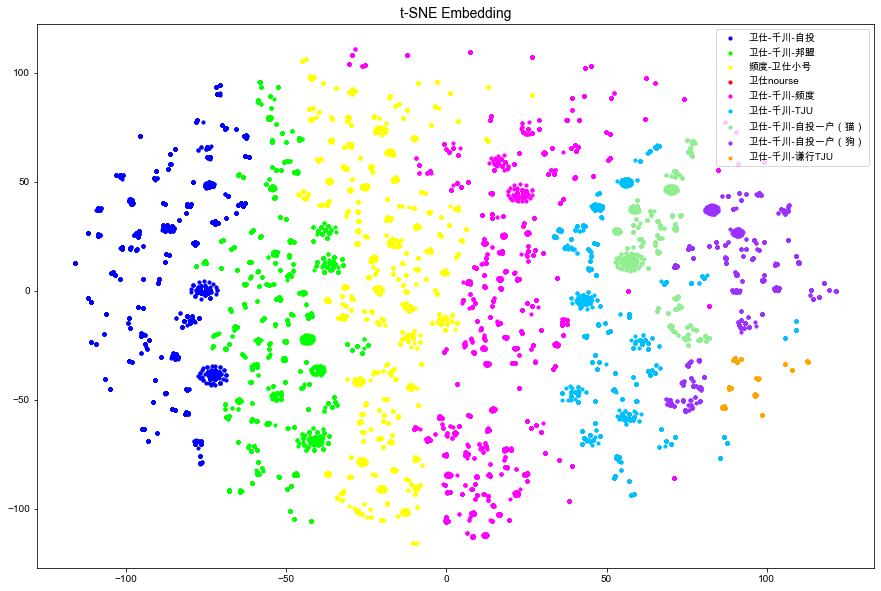

In [28]:
qc_data, qc_detail = data_pre_handle_toDict()
qc_data,qc_data_label_Tju = class_data_Tju(qc_data, qc_detail)
class_ = qc_data['class_id']

# qc_data=MinMaxScaler().fit_transform(qc_data[qc_data_label_Tju].iloc[:,:-1])
# qc_data=pd.DataFrame(qc_data)

# qc_data=StandardScaler().fit_transform(qc_data)
# qc_data=pd.DataFrame(qc_data)

qc_data=Normalizer().fit_transform(qc_data[qc_data_label_Tju].iloc[:,:-1])
qc_data=pd.DataFrame(qc_data)
#合并表格
qc_data = pd.merge(qc_data, class_,left_index=True,right_index=True)

qc_data.columns = qc_data_label_Tju

result, label, n_samples, n_features = Train(qc_data,qc_data_label_Tju)
fig = PlotEmbedding(result, label, n_samples)

if time_type == time_selcet[0]:
    if (os.path.exists('./Tju_start_end')):
        plt.savefig('./Tju_start_end/'+ cday + '~~' + cday2 +'(Tju_tsne).png', bbox_inches='tight')    
    elif not (os.path.exists('./Tju_start_end')):
        os.makedirs('./Tju_start_end')
        plt.savefig('./Tju_start_end/'+ cday + '~~' + cday2 +'(Tju_tsne).png', bbox_inches='tight')    
elif time_type == time_selcet[1]:
    if (os.path.exists('./Tju_time_interval')):
        plt.savefig('./Tju_time_interval/'+ input_time[1:]+' '+min_day+' '+min_hour+':'+min_minute+':'+min_second+' '+max_day+' '+max_hour+':'+max_minute+':'+max_second +'(Tju_tsne).png', bbox_inches='tight')
    elif not (os.path.exists('./Tju_time_interval')):
        os.makedirs('./Tju_time_interval')
        plt.savefig('./Tju_time_interval/'+ input_time[1:]+' '+min_day+' '+min_hour+':'+min_minute+':'+min_second+' '+max_day+' '+max_hour+':'+max_minute+':'+max_second +'(Tju_tsne).png', bbox_inches='tight')


#plt.savefig('/Users/jiangshihua/Desktop/项目/picture/'+input_time+'_'+min_day+'号~'+max_day+'号_'+min_hour+'时~'+max_hour+'时_'+min_minute+'分~'+max_minute+'分_'+min_second+'秒~'+max_second+'秒_roi_tsne'+'.png', bbox_inches='tight')
plt.show()

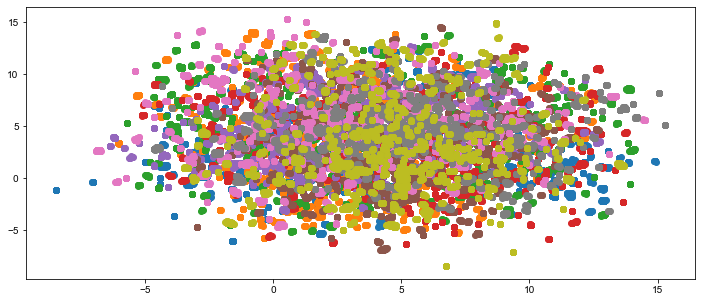

In [29]:
#导入数据
#data_fea = qc_data[qc_data_label_roi].iloc[:,:-1]#取数据中指标所在的列
#data_fea = data_fea.fillna(0)#填补缺失值
 
# #标准化
# data_mean = data_fea.mean()
# data_std = data_fea.std()
# data_fea = (data_fea - data_mean)/data_std
 
#降维
#umap_data = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3).fit_transform(data_fea.values)
umap_data = umap.UMAP(n_components=9).fit_transform(qc_data[qc_data_label_Tju].iloc[:,:-1].values)


#归一化
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# umap_data = min_max_scaler.fit_transform(umap_data)
 
#绘制图像
plt.figure(figsize=(12,5))
plt.scatter(umap_data[:,0], umap_data[:,1])
plt.scatter(umap_data[:,1], umap_data[:,2])
plt.scatter(umap_data[:,2], umap_data[:,3])
plt.scatter(umap_data[:,3], umap_data[:,4])
plt.scatter(umap_data[:,4], umap_data[:,5])
plt.scatter(umap_data[:,5], umap_data[:,6])
plt.scatter(umap_data[:,6], umap_data[:,7])
plt.scatter(umap_data[:,7], umap_data[:,8])
plt.scatter(umap_data[:,8], umap_data[:,0])
if time_type == time_selcet[0]:
    if (os.path.exists('./Tju_start_end')):
        plt.savefig('./Tju_start_end/'+ cday + '~~' + cday2 +'(Tju_umap).png', bbox_inches='tight')    
    elif not (os.path.exists('./Tju_start_end')):
        os.makedirs('./Tju_start_end')
        plt.savefig('./Tju_start_end/'+ cday + '~~' + cday2 +'(Tju_umap).png', bbox_inches='tight')    
elif time_type == time_selcet[1]:
    if (os.path.exists('./Tju_time_interval')):
        plt.savefig('./Tju_time_interval/'+ input_time[1:]+' '+min_day+' '+min_hour+':'+min_minute+':'+min_second+' '+max_day+' '+max_hour+':'+max_minute+':'+max_second +'(Tju_umap).png', bbox_inches='tight')
    elif not (os.path.exists('./Tju_time_interval')):
        os.makedirs('./Tju_time_interval')
        plt.savefig('./Tju_time_interval/'+ input_time[1:]+' '+min_day+' '+min_hour+':'+min_minute+':'+min_second+' '+max_day+' '+max_hour+':'+max_minute+':'+max_second +'(Tju_umap).png', bbox_inches='tight')

<AxesSubplot:>

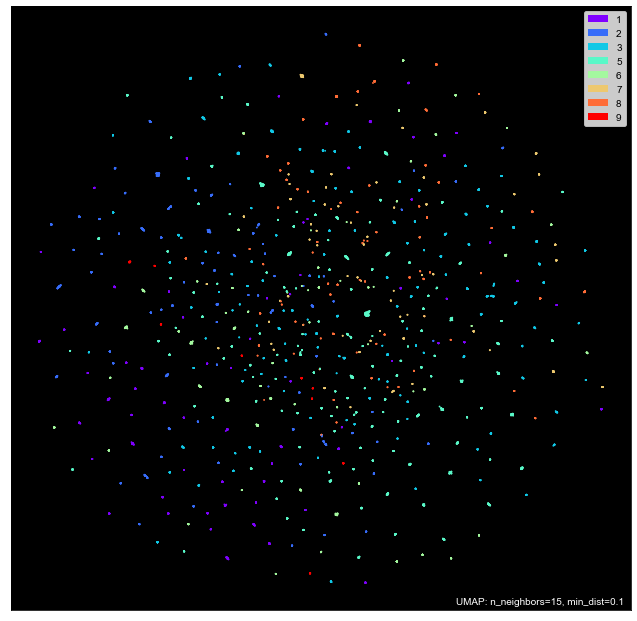

In [30]:
# #umap绘图
# #qc_data_label_roi  
# data, label, n_samples, n_features = GetData(qc_data,qc_data_label_Tju)
# label_shape = np.array(label)

# pipe = make_pipeline(SimpleImputer(), QuantileTransformer())
# X_processed = pipe.fit_transform(data) 
# manifold = umap.UMAP().fit(X_processed,label_shape)
# umap.plot.points(manifold, labels=label_shape, theme="fire")